In [1]:
library(dplyr)
library(data.table)
library(ggplot2)
# library(animation)
lon_range <- readRDS("lon_range.Rds")
lat_range <- readRDS("lat_range.Rds")
banking <- readRDS("Banking_Analysis/estimated_banking.Rds")
climb <- readRDS("Flight_Phase_Identification/estimated_flight_phase.Rds")
ac_data <- fread("../../samples_with_jfk_landing_flag.csv")
ac_data$ts_readable <- as.POSIXct.numeric(as.numeric(ac_data$ts), origin="1970-01-01")
ac_data$jfk_landing_flag[is.na(ac_data$jfk_landing_flag)] <- F


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last



In [2]:
ac_data <- merge(ac_data, climb, by = c("id", "ts_readable", "altitude"), all = T)
ac_data <- merge(ac_data, banking, by = c("id", "ts", "azimuth"), all = T)
nms <- colnames(ac_data)
nms[which(nms == "decision_point")] <- "altitude_decision_point"
nms[which(nms == "turn")] <- "turn_point"
names(ac_data) <- nms
ac_data$altitude_decision_point[is.na(ac_data$altitude_decision_point)] <- F
ac_data$turn_point[is.na(ac_data$turn_point)] <- F
setorder(ac_data, id, ts)
ac_data[, c("id_start_ts", "id_end_ts") := list(ts[1], ts[.N]), by = "id"]
uniq_id <- unique(ac_data$id)
chosen_id <- uniq_id[sample(1:length(uniq_id), 1)]
ac_data[, c("total_turns", "max_id_altitude") := list(sum(turn_point), max(altitude)), by = "id"]

In [ ]:
# ac_data[, "lga_landing_flag" := any(destination == "LGA"), by = "id"]

In [ ]:
# lga_last_row <- ac_data[ac_data$lga_landing_flag, .SD[.N], by = "id"]
# plot(lga_last_row$lon, lga_last_row$lat)

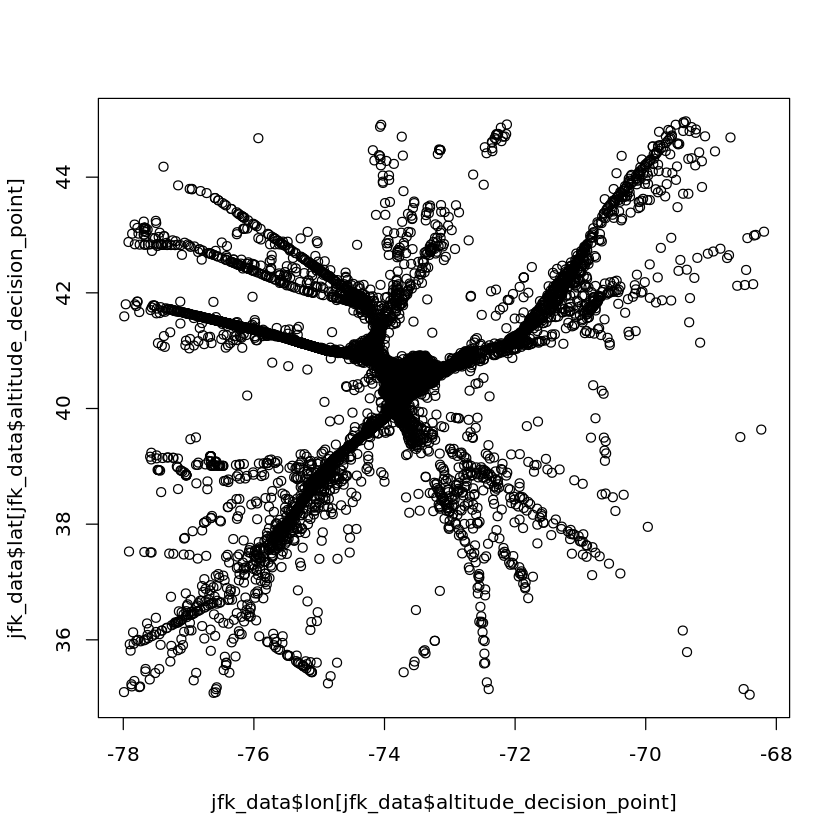

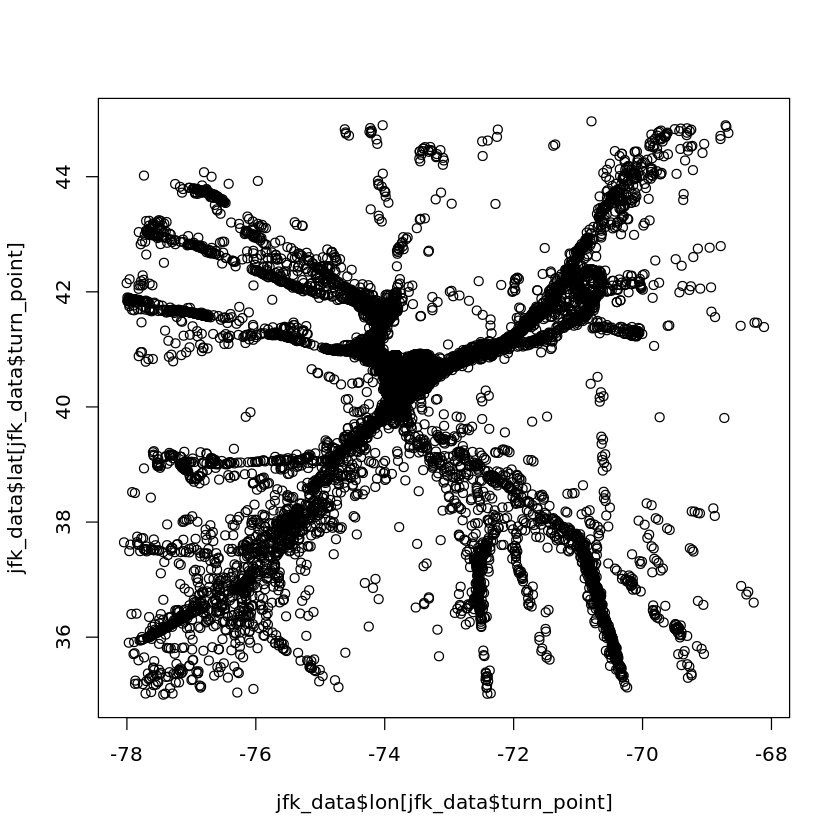

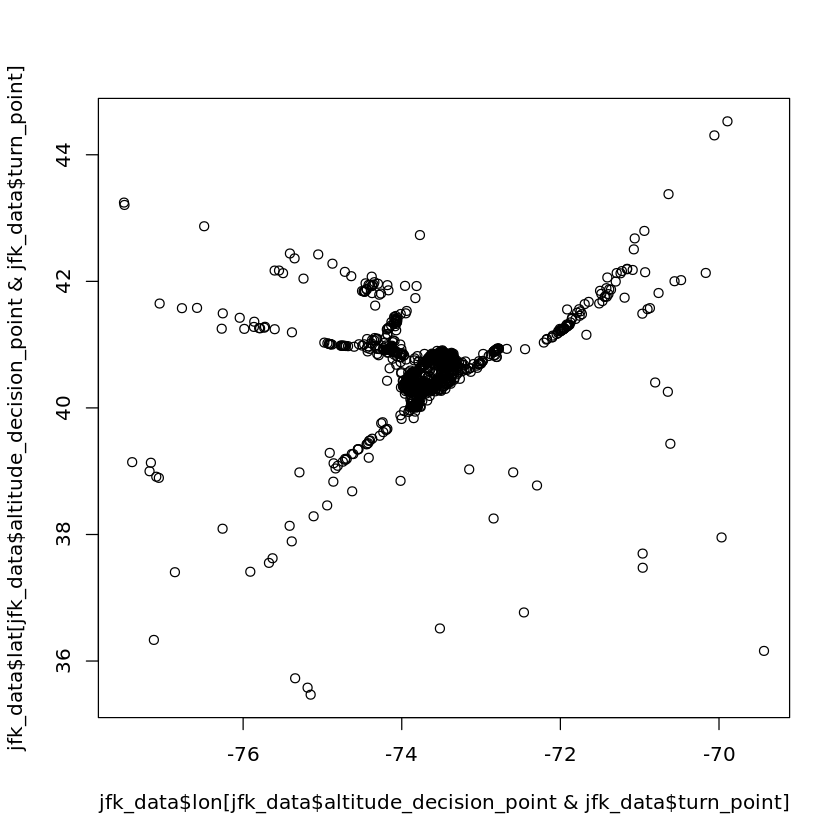

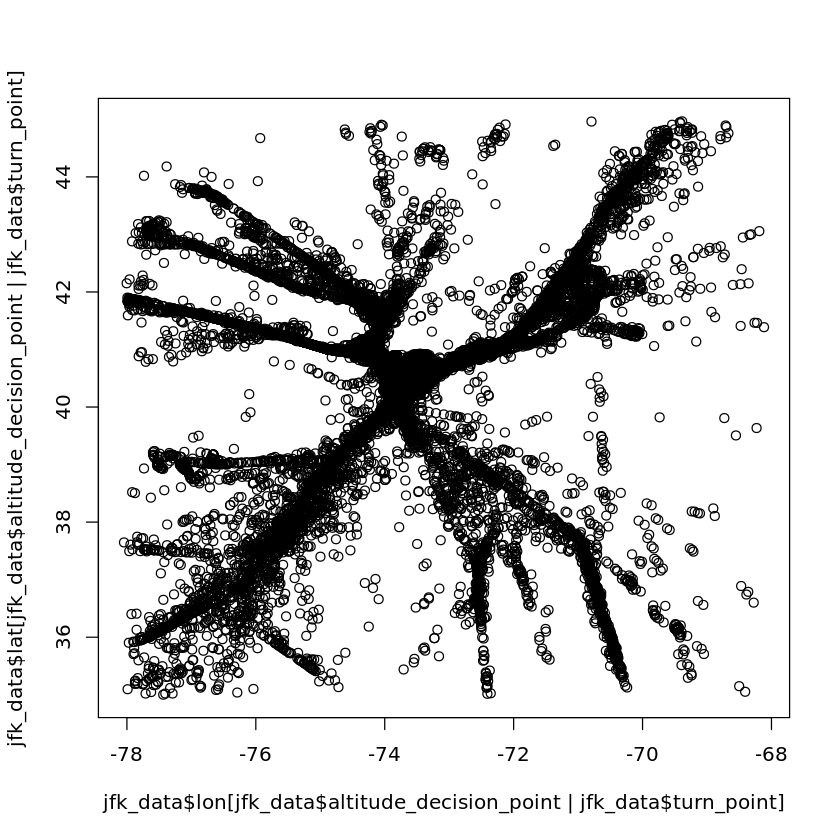

In [3]:
jfk_data <- ac_data[ac_data$jfk_landing_flag, ]
jfk_data <- jfk_data[, .SD[-1], by = "id"]
plot(jfk_data$lon[jfk_data$altitude_decision_point], jfk_data$lat[jfk_data$altitude_decision_point])
plot(jfk_data$lon[jfk_data$turn_point], jfk_data$lat[jfk_data$turn_point])
plot(jfk_data$lon[jfk_data$altitude_decision_point & jfk_data$turn_point],
     jfk_data$lat[jfk_data$altitude_decision_point & jfk_data$turn_point])
plot(jfk_data$lon[jfk_data$altitude_decision_point | jfk_data$turn_point],
     jfk_data$lat[jfk_data$altitude_decision_point | jfk_data$turn_point])

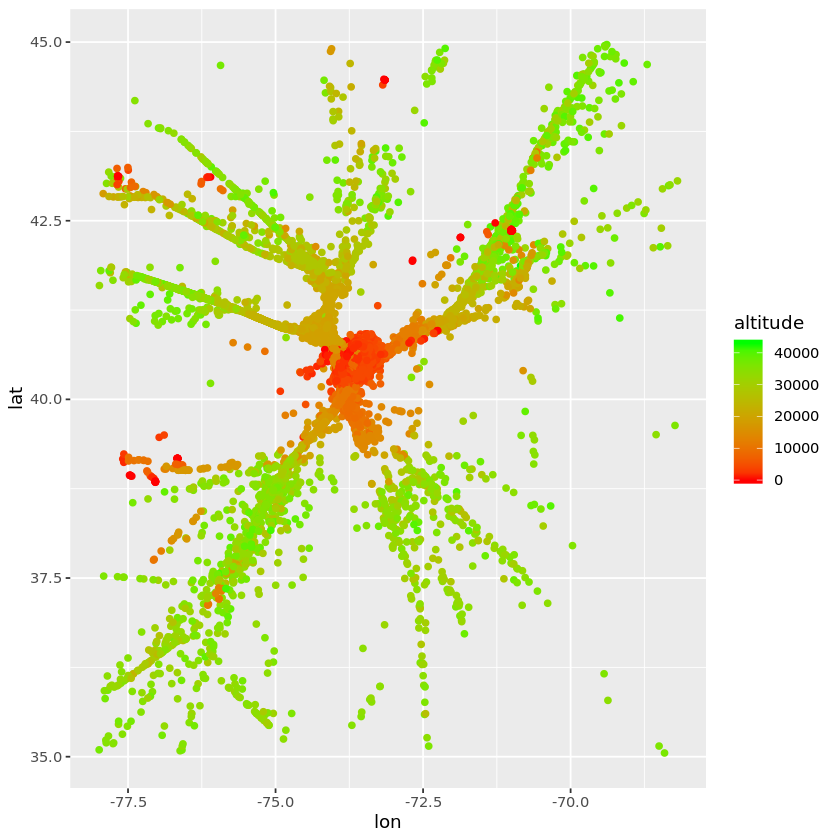

In [4]:
ggplot(data = jfk_data[jfk_data$altitude_decision_point, ], aes(x = lon, y = lat)) + geom_point(aes(col = altitude)) + scale_colour_gradient(low = "red", high = "green")

In [ ]:
# no_turns <- ac_data[ac_data$total_turns == 0 & ac_data$max_id_altitude >= 20000]
# ggplot(no_turns[no_turns$id == no_turns$id[1]], aes(x = lon, y = lat)) +
#   geom_path(aes(color = ts), arrow = arrow(angle = 18, length = unit(0.065, "inches"), type = 'closed')) +
#   scale_color_gradient(low = "red", high = "green")
# # plot(no_turns$lon[no_turns$id == no_turns$id[1]], no_turns$lat[no_turns$id == no_turns$id[1]])
# plot(no_turns$ts_readable[no_turns$id == no_turns$id[1]], no_turns$azimuth[no_turns$id == no_turns$id[1]])

In [5]:
library(dbscan)

In [7]:
db <- dbscan(x = jfk_data[jfk_data$altitude_decision_point, c("lon", "lat", "altitude")], eps = 0.15, minPts = 5)

Warning message in axis(side = side, at = at, labels = labels, ...):
""frame" is not a graphical parameter"Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""frame" is not a graphical parameter"Warning message in axis(side = side, at = at, labels = labels, ...):
""frame" is not a graphical parameter"Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""frame" is not a graphical parameter"Warning message in axis(side = side, at = at, labels = labels, ...):
""frame" is not a graphical parameter"Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""frame" is not a graphical parameter"Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""frame" is not a graphical parameter"Warning message in axis(side = side, at = at, labels = labels, ...):
""frame" is not a graphical parameter"Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""frame" is not a graphical parameter"Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""fr

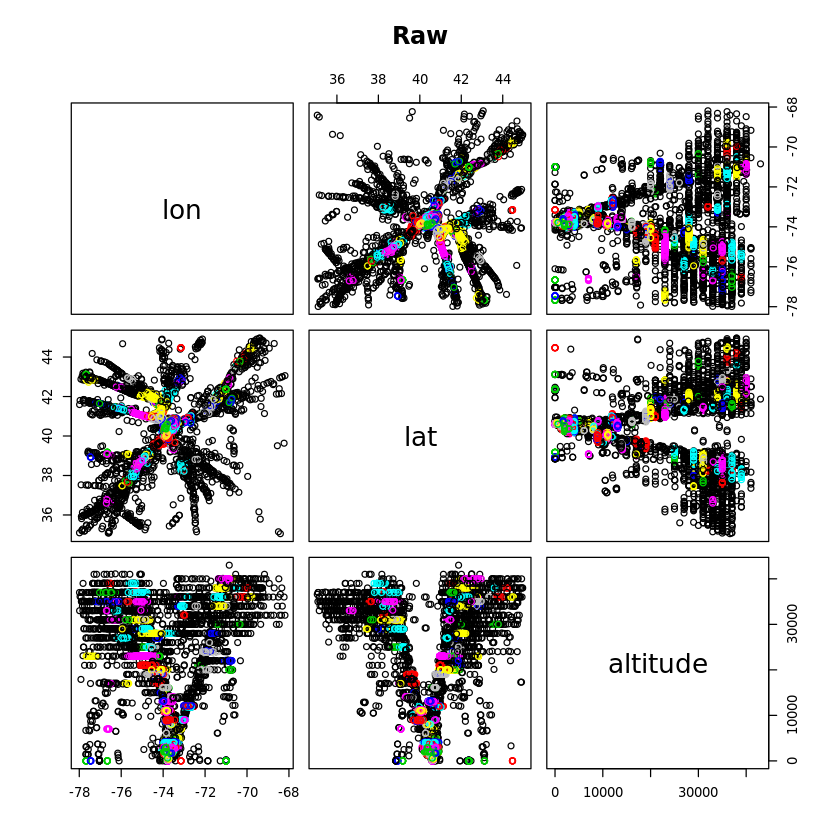

In [9]:
plot(jfk_data[jfk_data$altitude_decision_point, c("lon", "lat", "altitude")], main = "Raw", frame = FALSE, col = db$cluster + 1)

Warning message in axis(side = side, at = at, labels = labels, ...):
""frame" is not a graphical parameter"Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""frame" is not a graphical parameter"Warning message in axis(side = side, at = at, labels = labels, ...):
""frame" is not a graphical parameter"Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""frame" is not a graphical parameter"Warning message in axis(side = side, at = at, labels = labels, ...):
""frame" is not a graphical parameter"Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""frame" is not a graphical parameter"Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""frame" is not a graphical parameter"Warning message in axis(side = side, at = at, labels = labels, ...):
""frame" is not a graphical parameter"Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""frame" is not a graphical parameter"Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""fr

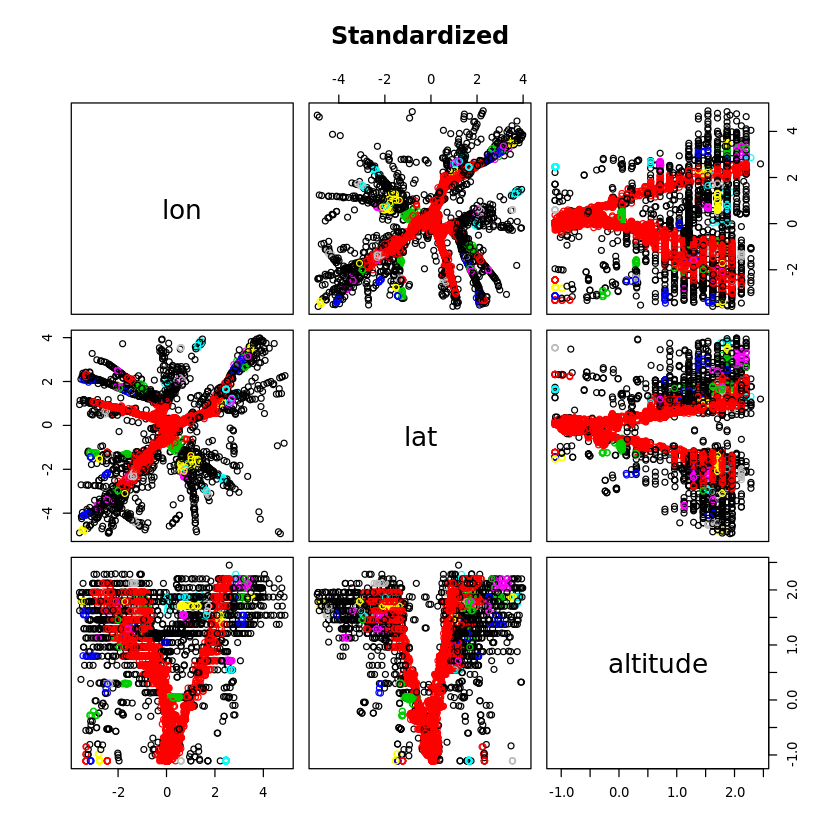

In [12]:
df <- data.frame(scale(jfk_data[jfk_data$altitude_decision_point, c("lon", "lat", "altitude")]))
db1 <- dbscan(x = df, eps = 0.15, minPts = 5)
plot(df, main = "Standardized", frame = FALSE, col = db1$cluster + 1)


Attaching package: 'BBmisc'

The following objects are masked from 'package:dplyr':

    coalesce, collapse

The following object is masked from 'package:base':

    isFALSE

Warning message in axis(side = side, at = at, labels = labels, ...):
""frame" is not a graphical parameter"Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""frame" is not a graphical parameter"Warning message in axis(side = side, at = at, labels = labels, ...):
""frame" is not a graphical parameter"Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""frame" is not a graphical parameter"Warning message in axis(side = side, at = at, labels = labels, ...):
""frame" is not a graphical parameter"Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""frame" is not a graphical parameter"Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""frame" is not a graphical parameter"Warning message in axis(side = side, at = at, labels = labels, ...):
""frame" is not a graphical pa

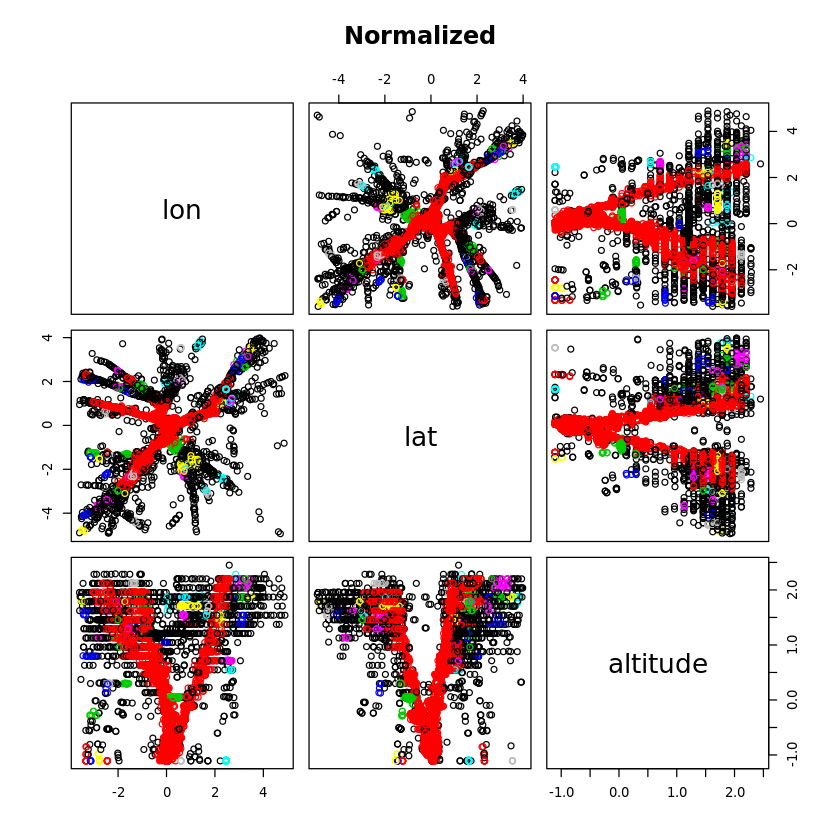

In [13]:
library(BBmisc)
df1 <- normalize(jfk_data[jfk_data$altitude_decision_point, c("lon", "lat", "altitude")], range = c(0, 1))
db2 <- dbscan(x = df1, eps = 0.15, minPts = 5)
plot(col = db2$cluster + 1, df1, main = "Normalized", frame = FALSE)

In [14]:
saveRDS(db2, "altitude_dbscan_model.Rds")
lon_range <- range(jfk_data$lon[jfk_data$altitude_decision_point])
lat_range <- range(jfk_data$lat[jfk_data$altitude_decision_point])
altitude_range <- range(jfk_data$altitude[jfk_data$altitude_decision_point])
saveRDS(lon_range, "lon_range.Rds")
saveRDS(lat_range, "lat_range.Rds")
saveRDS(altitude_range, "altitude_range.Rds")

In [19]:
# Requires distance of test set points from each train set point
# Not working after changing to distance matrix; will not be fixed
predict_altitude_cluster <- function(test_set, train_set, lon_col = "lon", lat_col = "lat", alt_col = "altitude") {
    mdl <- readRDS("altitude_dbscan_model.Rds")
    df <- data.frame(test_set)
    lon_range <- readRDS("lon_range.Rds")
    lat_range <- readRDS("lat_range.Rds")
    altitude_range <- readRDS("altitude_range.Rds")
    test_set[, lon_col] <- (test_set[, lon_col] - lon_range[1])/(lon_range[2] - lon_range[1])
    test_set[, lat_col] <- (test_set[, lat_col] - lat_range[1])/(lat_range[2] - lat_range[1])
    test_set[, alt_col] <- (test_set[, alt_col] - altitude_range[1])/(altitude_range[2] - altitude_range[1])
    return(predict(mdl, data = train_set, newdata = test_set))
}

In [20]:
# jfk_data$cluster_id <- -1
# cluster_id <- predict_altitude_cluster(jfk_data)
# length(cluster_id)
# sum(jfk_data$altitude_decision_point, na.rm = T)

ERROR: Error in frNN(rbind(data, newdata), eps = object$eps, sort = TRUE, ...): x has to be a numeric matrix.


In [ ]:
range(cluster_id)

In [ ]:
jfk_data$cluster_id[jfk_data$altitude_decision_point] <- cluster_id

In [ ]:
table(cluster_id)

In [ ]:
db3 <- fpc::dbscan(data = jfk_data[jfk_data$altitude_decision_point, c("lon", "lat")], eps = 0.15, MinPts = 5)
plot(db3, jfk_data[jfk_data$altitude_decision_point, c("lon", "lat")], main = "Raw", frame = FALSE)

In [ ]:
df2 <- scale(jfk_data[jfk_data$altitude_decision_point, c("lon", "lat")])
db4 <- fpc::dbscan(data = df2, eps = 0.15, MinPts = 5)
plot(db4, df2, main = "Standardized", frame = FALSE)

In [ ]:
df3 <- normalize(jfk_data[jfk_data$altitude_decision_point, c("lon", "lat")])
db5 <- fpc::dbscan(data = df3, eps = 0.15, MinPts = 5)
plot(db5, df3, main = "Normalized", frame = FALSE)

In [ ]:
labels1 <- predict(db5, df3)

In [ ]:
labels2 <- predict(db4, df2)

In [ ]:
head(labels1)
head(labels2)

In [ ]:
sum(labels1 != labels2)

# Observation

- Normalized and standardized data sets give the same result

In [ ]:
db6 <- fpc::dbscan(data = jfk_data[jfk_data$turn, c("lon", "lat", "azimuth")], eps = 0.15, MinPts = 5)
plot(db6, jfk_data[jfk_data$turn, c("lon", "lat", "azimuth")], main = "Raw", frame = FALSE)

In [ ]:
df4 <- data.frame(scale(jfk_data[jfk_data$turn, c("lon", "lat", "azimuth")]))
db7 <- fpc::dbscan(data = df4, eps = 0.15, MinPts = 5)
plot(db7, df4, main = "Standardized", frame = FALSE)

In [ ]:
db8 <- fpc::dbscan(data = jfk_data[jfk_data$turn, c("lon", "lat")], eps = 0.15, MinPts = 5)
plot(db8, jfk_data[jfk_data$turn, c("lon", "lat")], main = "Raw", frame = FALSE)

In [ ]:
# colnames(jfk_data)

In [ ]:
db9 <- fpc::dbscan(data = jfk_data[jfk_data$turn, c("lon", "lat", "avg_bank_rate")], eps = 0.15, MinPts = 5)
plot(db9, jfk_data[jfk_data$turn, c("lon", "lat", "avg_bank_rate")], main = "Raw", frame = FALSE)

In [ ]:
df5 <- data.frame(scale(jfk_data[jfk_data$turn, c("lon", "lat", "avg_bank_rate")]))
db10 <- fpc::dbscan(data = df5, eps = 0.15, MinPts = 5)
plot(db7, df4, main = "Standardized", frame = FALSE)

In [ ]:
# dir.create("airports", showWarnings = F)
# max_airport <- function(airports) {
#     airports <- airports[airports != ""]
#     if(length(airports) >= 1) {
#         tbl <- table(airports)
#         tbl <- sort(tbl, decreasing = T)
#         return(names(tbl)[1])
#     } else {
#         return("")
#     }
# }

# airport_df <- ac_data %>% group_by(id) %>% summarize(max_ap = max_airport(destination))

In [ ]:
# mean(airport_df$max_ap == "")

In [ ]:
# ac_data <- merge(ac_data, airport_df, by = "id", all = T)

In [ ]:
# for(ap1 in unique(airport_df$max_ap[airport_df$max_ap != ""])) {
#     tryCatch({
#         ap_data <- ac_data[ac_data$max_ap == ap1, ]
#         ap_df2 <- data.frame(scale(ap_data[ap_data$altitude_decision_point, c("lon", "lat", "altitude")]))
#         ap_db4 <- fpc::dbscan(data = ap_df2, eps = 0.15, MinPts = 5)
#         png(paste0("airports/", ap1, ".png"))
#         plot(ap_db4, ap_df2, main = "Standardized", frame = FALSE)
#         dev.off()
#     }, error = function(e) dev.off())
# }

In [ ]:
# colnames(ac_data)

In [ ]:
# ap1 = "JFK"
# ap_data <- ac_data[ac_data$max_ap == ap1, ]
# ap_df2 <- data.frame(scale(ap_data[ap_data$altitude_decision_point, c("lon", "lat", "altitude")]))
# ap_db4 <- fpc::dbscan(data = ap_df2, eps = 0.15, MinPts = 5)
# plot(ap_db4, ap_df2, main = "Standardized", frame = FALSE)

# Understanding the pattern

It looks like some kind of coordinate transform is required to understand the underlying patterns in azimuth - altitude - lon - lat

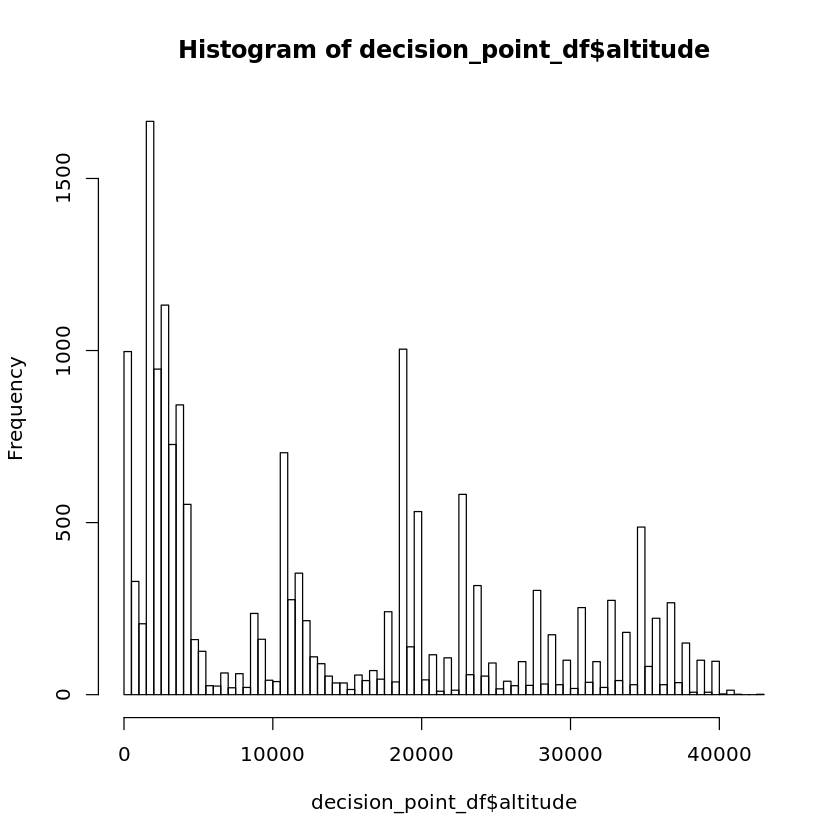

In [21]:
library(geosphere)
decision_point_df <- jfk_data[jfk_data$altitude_decision_point, ]
hist(decision_point_df$altitude, breaks = 100)

In [22]:
library(parallel)
library(dbscan)
altitude_splits <- c(min(decision_point_df$altitude) - 1, 7500, 10000, 17000,
                     21000, 26000, max(decision_point_df$altitude))
cuts <- cut(decision_point_df$altitude, breaks = altitude_splits, include.lowest = F, right = T)
decision_point_df_splits <- split(decision_point_df, cuts)
dir.create("dbscan", showWarnings = F)

In [25]:
cl <- makeCluster(length(decision_point_df_splits))
clusterExport(cl, list("png", "paste0", "as.dist", "distm", "dbscan", "plot", "dev.off"))
parLapply(cl = cl, X = decision_point_df_splits, fun = function(decision_point_df_split) {
  png(paste0("dbscan/", decision_point_df_split$altitude[1], ".png"), width = 600, height = 400)
  dist_mat <- as.dist(distm(decision_point_df_split[, c("lon", "lat")]))
  db <- dbscan(dist_mat, eps = 0.15, minPts = 5)
  plot(decision_point_df_split[, c("lon", "lat")], main = "Raw", frame = FALSE, col = db$cluster + 1)
  dev.off()
})

$`(-1,7.5e+03]`
null device 
          1 

$`(7.5e+03,1e+04]`
null device 
          1 

$`(1e+04,1.7e+04]`
null device 
          1 

$`(1.7e+04,2.1e+04]`
null device 
          1 

$`(2.1e+04,2.6e+04]`
null device 
          1 

$`(2.6e+04,4.3e+04]`
null device 
          1

In [26]:
stopCluster(cl)

In [29]:
names(decision_point_df_splits)

[1] "(-1,7.5e+03]"      "(7.5e+03,1e+04]"   "(1e+04,1.7e+04]"  
[4] "(1.7e+04,2.1e+04]" "(2.1e+04,2.6e+04]" "(2.6e+04,4.3e+04]"

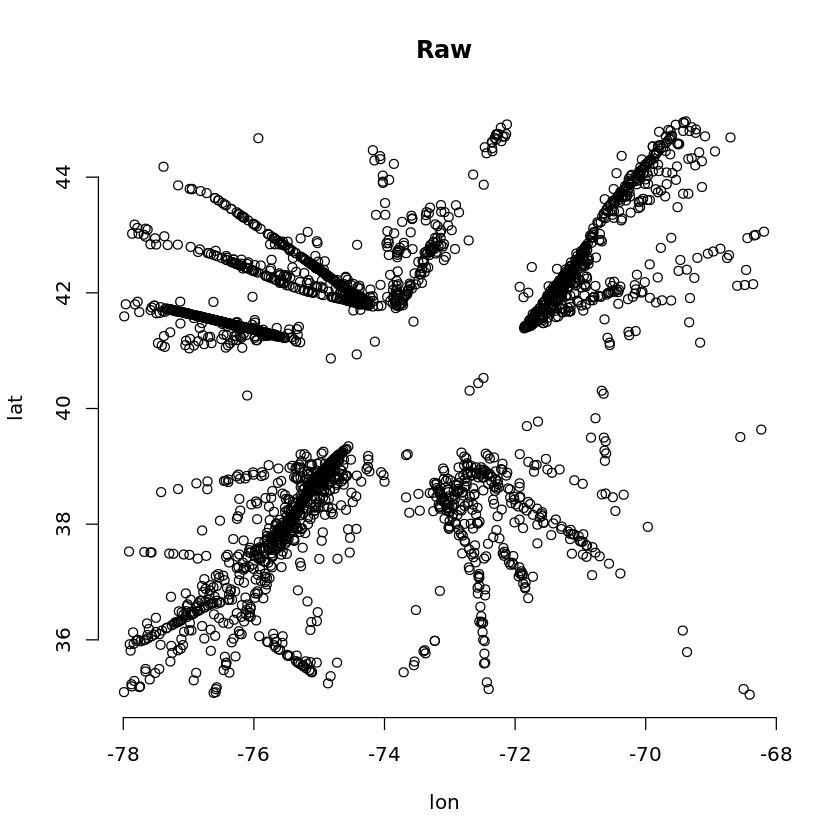

In [30]:
decision_point_df_split <- decision_point_df_splits[[6]]
dist_mat <- as.dist(distm(decision_point_df_split[, c("lon", "lat")]))

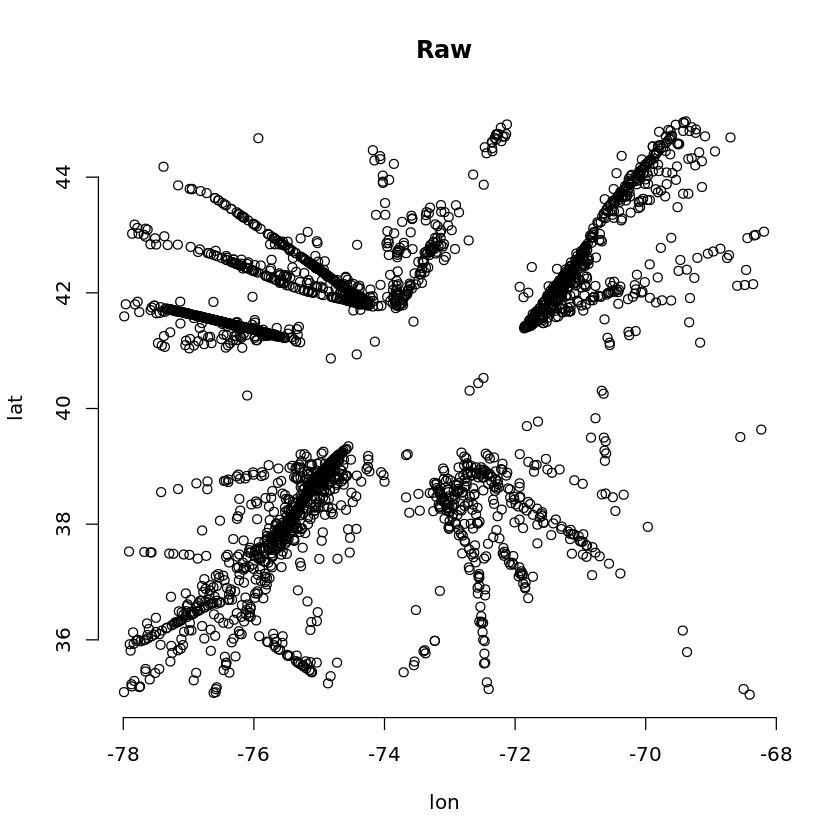

In [51]:
db <- dbscan(dist_mat, eps = 0.01, minPts = 2)
plot(decision_point_df_split[, c("lon", "lat")], main = "Raw", frame = FALSE, col = db$cluster + 1)

In [52]:
table(db$cluster)


   0    1 
3233    2 